In [79]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import copy

In [107]:
data = sm.datasets.co2.load_pandas().data
data = pd.DataFrame(data)
data.dropna(inplace = True)
data.shape

(2225, 1)

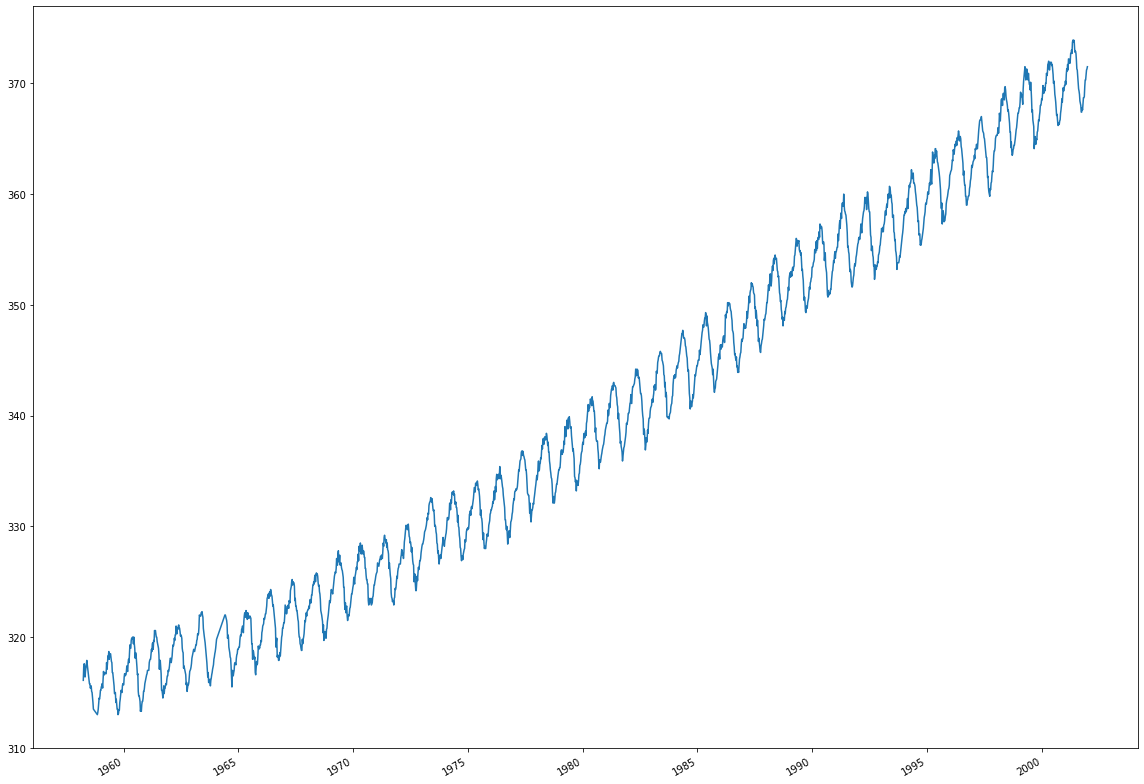

In [81]:
fig , ax = plt.subplots(figsize = (16 , 11))
ax.plot(data['co2'])


fig.autofmt_xdate()
plt.tight_layout()

In [82]:
data = data.interpolate


# *Predict the next time step using the previous observation*

 #  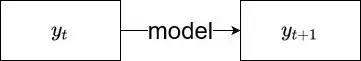

In [108]:
#we need to format the dataset such that the current observation is a feature to predict the next observation (the target).
df = data.copy()
df['N'] = df['co2'].shift(-1)

In [85]:
#we have weekly data, and there are 52 weeks in a year, it means that the last 104 samples are kept for the test set.
train = df[:-104]
test = df[-104:]
test.drop(test.tail(1).index)
# drop last row which having NAN value

,co2,N
2000-01-08,368.5,369.0
2000-01-15,369.0,369.8
2000-01-22,369.8,369.2
2000-01-29,369.2,369.1
2000-02-05,369.1,369.6
...,...,...
2001-11-24,370.3,370.3
2001-12-01,370.3,370.8
2001-12-08,370.8,371.2
2001-12-15,371.2,371.3


In [86]:
test = test.copy()
test['baseline_pred'] = test['co2']


In [87]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['co2'].values.reshape(-1,1)
y_train = train['N'].values.reshape(-1,1)
X_test = test['co2'].values.reshape(-1,1)


In [88]:
#model DecisionTree
model = DecisionTreeRegressor(random_state=42)
model.fit(X = X_train , y = y_train)

DecisionTreeRegressor(random_state=42)

In [89]:
predict = model.predict(X_test)
test['Predict_Decision_Tree'] = predict
test

,co2,N,baseline_pred,Predict_Decision_Tree
2000-01-08,368.5,369.0,368.5,368.650000
2000-01-15,369.0,369.8,369.0,368.500000
2000-01-22,369.8,369.2,369.8,369.400000
2000-01-29,369.2,369.1,369.2,369.100000
2000-02-05,369.1,369.6,369.1,368.800000
...,...,...,...,...
2001-12-01,370.3,370.8,370.3,370.533333
2001-12-08,370.8,371.2,370.8,370.800000
2001-12-15,371.2,371.3,371.2,371.000000
2001-12-22,371.3,371.5,371.3,371.000000


In [90]:
#model Gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X = X_train , y = y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred
test

,co2,N,baseline_pred,Predict_Decision_Tree,gbr_pred
2000-01-08,368.5,369.0,368.5,368.650000,368.568543
2000-01-15,369.0,369.8,369.0,368.500000,368.800877
2000-01-22,369.8,369.2,369.8,369.400000,369.536731
2000-01-29,369.2,369.1,369.2,369.100000,369.091140
2000-02-05,369.1,369.6,369.1,368.800000,368.800877
...,...,...,...,...,...
2001-12-01,370.3,370.8,370.3,370.533333,370.528161
2001-12-08,370.8,371.2,370.8,370.800000,370.689143
2001-12-15,371.2,371.3,371.2,371.000000,371.030505
2001-12-22,371.3,371.5,371.3,371.000000,371.030505


In [91]:
# use the mean absolute percentage error (MAPE)
#it return a percentage
#Make sure to only apply it when you don’t have values close to 0
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


In [92]:
baseline_mape = mape(test['N'], test['baseline_pred'])
dt_mape = mape(test['N'], test['Predict_Decision_Tree'])
gbr_mape = mape(test['co2'], test['gbr_pred'])

In [93]:
#lower the MAPE better the results
result = [baseline_mape , dt_mape , gbr_mape]
for i in result:
  print("MAPE result : " , i)

MAPE result :  0.1
MAPE result :  0.21
MAPE result :  0.15


# *Predict the next time step using a sequence of past observations*
#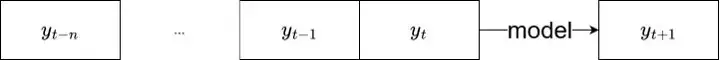

In [94]:

#For that write the function who shifts the new columns as predictors for like time steps or something
def window_shift(window_length : int , data : pd.DataFrame) -> pd.DataFrame : # taking two arguments
#first "window_length" for to choose how many observation columns we want to produce
#second "data" for to mention data where we do all this messed up 
  df = data.copy()

  i = 1
  while i < window_length:
    df[f'x_{i}'] = df['co2'].shift(-1)
    i = i+1 

  if i == window_length:
        df['y'] = df['co2'].shift(-i)  

  # Drop rows where there is a NaN
  df = df.dropna(axis=0)      
  return df

In [113]:
new_df = window_shift(5, data)
new_df

,co2,x_1,x_2,x_3,x_4,y
1958-03-29,316.1,317.3,317.3,317.3,317.3,316.9
1958-04-05,317.3,317.6,317.6,317.6,317.6,317.5
1958-04-12,317.6,317.5,317.5,317.5,317.5,317.9
1958-04-19,317.5,316.4,316.4,316.4,316.4,315.8
1958-04-26,316.4,316.9,316.9,316.9,316.9,315.8
...,...,...,...,...,...,...
2001-10-27,368.7,368.7,368.7,368.7,368.7,370.3
2001-11-03,368.7,368.8,368.8,368.8,368.8,370.8
2001-11-10,368.8,369.7,369.7,369.7,369.7,371.2
2001-11-17,369.7,370.3,370.3,370.3,370.3,371.3


In [114]:
#Resampling the data using train test split
from sklearn.model_selection import train_test_split

X = new_df[['co2', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)


In [115]:
#again use DecisionTree
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

In [116]:
#again use Gradient Boosting
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

In [117]:
#again define baseline model this kind of situation , We only predict mean of input values from X_test
baseline_5_mape = []

for row in X_test:
    baseline_5_mape.append(np.mean(row))
    

In [118]:
baseline_5_mape = mape(y_test, baseline_5_mape)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)

In [119]:
#lower the MAPE better the results
result = [baseline_5_mape , dt_5_mape , gbr_5_mape]
for i in result:
  print("MAPE result : " , i)

MAPE result :  0.32
MAPE result :  2.23
MAPE result :  2.28


# *Predict a sequence of future time steps using a sequence of past observations*
#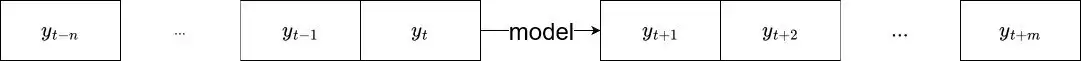

In [122]:
#For that write the function who shifts the new columns as predictors for like time steps or something
def window_input_output(input_length : int ,output_length : int ,  data : pd.DataFrame) -> pd.DataFrame : # taking three arguments
#first "input_length" for to choose how many observation columns we want to produce
#second "output_length" to make evaluation column
#and third for "data" where we design the our input and output columns
  df = data.copy()

  i = 1
  while i < input_length:
    df[f'x_{i}'] = df['co2'].shift(-1)
    i = i+1 
  
  j = 0
  while j < output_length :
    df[f'y_{j}'] = df['co2'].shift(-output_length-j)
    j = j+1

  
  df = df.dropna(axis = 0)

  return df 


In [129]:
seq_df = window_input_output(26, 26, data)
seq_df

,co2,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
1958-03-29,316.1,317.3,317.3,317.3,317.3,317.3,317.3,317.3,317.3,317.3,...,318.0,318.4,318.5,318.1,317.8,317.7,316.8,316.8,316.4,316.1
1958-04-05,317.3,317.6,317.6,317.6,317.6,317.6,317.6,317.6,317.6,317.6,...,318.4,318.5,318.1,317.8,317.7,316.8,316.8,316.4,316.1,315.6
1958-04-12,317.6,317.5,317.5,317.5,317.5,317.5,317.5,317.5,317.5,317.5,...,318.5,318.1,317.8,317.7,316.8,316.8,316.4,316.1,315.6,314.9
1958-04-19,317.5,316.4,316.4,316.4,316.4,316.4,316.4,316.4,316.4,316.4,...,318.1,317.8,317.7,316.8,316.8,316.4,316.1,315.6,314.9,315.0
1958-04-26,316.4,316.9,316.9,316.9,316.9,316.9,316.9,316.9,316.9,316.9,...,317.8,317.7,316.8,316.8,316.4,316.1,315.6,314.9,315.0,314.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-09,369.6,369.3,369.3,369.3,369.3,369.3,369.3,369.3,369.3,369.3,...,367.4,367.8,367.6,368.1,368.7,368.7,368.8,369.7,370.3,370.3
2000-12-16,369.3,369.5,369.5,369.5,369.5,369.5,369.5,369.5,369.5,369.5,...,367.8,367.6,368.1,368.7,368.7,368.8,369.7,370.3,370.3,370.8
2000-12-23,369.5,369.8,369.8,369.8,369.8,369.8,369.8,369.8,369.8,369.8,...,367.6,368.1,368.7,368.7,368.8,369.7,370.3,370.3,370.8,371.2
2000-12-30,369.8,369.8,369.8,369.8,369.8,369.8,369.8,369.8,369.8,369.8,...,368.1,368.7,368.7,368.8,369.7,370.3,370.3,370.8,371.2,371.3


In [124]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'co2')

y_cols = [col for col in seq_df.columns if col.startswith('y')]
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

In [126]:
#Decision Tree 
dt_seq = DecisionTreeRegressor(random_state=42)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)

In [125]:
#Gradient Boosting
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

In [127]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))

In [128]:
#lower the MAPE better the results
result = [mape_dt_seq , mape_gbr_seq , mape_baseline ]
for i in result:
  print("MAPE result : " , i)

MAPE result :  0.49
MAPE result :  0.27
MAPE result :  0.36
